In [4]:
import os
import glob
import gudhi
import glob
import pandas as pd
import persim 
from persim import PersImage
from persim import PersistenceImager
from persim.landscapes import snap_pl, plot_landscape_simple, PersLandscapeApprox, PersLandscapeExact, average_approx, plot_landscape
from scipy.spatial import distance_matrix
import numpy as np
from itertools import combinations
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import re
from natsort import natsorted
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import norm

In [7]:
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
os.chdir('params_classified')
df_params_file = (pd.read_csv('params_file.csv'))

In [ ]:
os.chdir("..\\2paramsweep_data\\16082022_all2Params")

In [ ]:
ts = [250,300,350,400,450,500]
d_file = []
for ID in df_params_file.id:
    for t in ts:
        d_file.append(glob.glob(f'ID-{ID}_time-{t}_From*ParamSweep_Data.csv')[0])
d_files = natsorted(d_file)


In [23]:
# Store IDs and Times:
IDs = []
import re
for fname in d_files:
    res = re.findall("ID-(\d+)_time", fname)
    if not res: continue
    IDs.append(int(res[0])) 
    
Times = []
for fname in d_files:
    res = re.findall("_time-(\d+)_", fname)
    if not res: continue
    Times.append(int(res[0]))


In [24]:
ids = df_params_file[['id']].to_numpy()

m_status = df_params_file[['metastatic']].to_numpy()

metas_ind = ids[np.where(m_status == True)]
nonmetas_ind = ids[np.where(m_status == False)]

In [26]:
N = len(d_files)
dfs = [] # datafiles of simulation data stored here
for f in d_files:
    dfs.append(pd.read_csv(f))

In [27]:
# list of df of just stroma, tumour and macrophage and lists of np arrays of coords:
dfs_stroma = []
for i in range(N):
    dfs_stroma.append(dfs[i].loc[dfs[i]['celltypes'] == 'Stroma'])
dfs_tumour = []
for i in range(N):
    dfs_tumour.append(dfs[i].loc[dfs[i]['celltypes'] == 'Tumour'])
dfs_macrophage = []
for i in range(N):
    dfs_macrophage.append(dfs[i].loc[dfs[i]['celltypes'] == 'Macrophage'])
dfs_vessel = []
for i in range(N):
    dfs_vessel.append(dfs[i].loc[dfs[i]['celltypes'] == 'Vessel'])
dfs_necrosis = []
for i in range(N):
    dfs_necrosis.append(dfs[i].loc[dfs[i]['celltypes'] == 'Necrotic'])


array = dfs[0][["points_x", "points_y"]].to_numpy()
# numpy array with points for Stroma: 
coords_stroma = []
for i in range(N                                                                                                                                                                                                                                                                                   ):
    coords_stroma.append(dfs_stroma[i][['points_x','points_y']].to_numpy())
coords_tumour = []
for i in range(N):
    coords_tumour.append(dfs_tumour[i][['points_x','points_y']].to_numpy())
coords_macrophage =[]
for i in range(N):                  
    coords_macrophage.append(dfs_macrophage[i][['points_x','points_y']].to_numpy())
coords_vessel = []
for i in range(N):
    coords_vessel.append(dfs_vessel[i][['points_x','points_y']].to_numpy())                                  


In [30]:
def getTree(ID, dim = 0, EPS = 2):
   
 
    def getSC(k, MU): # k is index for coords_tumour; MU is radius for expansion
        ptset = coords_tumour[k]
        tree = gudhi.SimplexTree()
        N = len(ptset)

        P = np.array([25.25])
        dist2 = [np.linalg.norm(p) for p in (ptset - P)]

      #  print(np.amax(dist2))

        dist2centre = 50 - np.array(dist2)

        # Distances between points
        dist_self = distance_matrix(ptset, ptset)
        dist_pairs_with_identicals = np.argwhere( dist_self < MU ) 
        mask = (dist_pairs_with_identicals[:, 0] != dist_pairs_with_identicals[:,1])
        dist_pairs = dist_pairs_with_identicals[mask, :] 

        for i in range(N):
            tree.insert([i],dist2centre[i])

        for i,j in dist_pairs: 
            tree.insert([i,j], max(dist2centre[i],dist2centre[j]))

        tree.expansion(2) # adds all the 2 simplicies, with filtration value being max edge filtration value. 
        return tree

    trees = []
    bars_0 = []
    bars_1 = []

    ind = np.where(np.array(IDs) == ID)
    id_number = ind[0]

    for n in id_number:
        tree = getSC(n,EPS)
        trees.append(tree)
        tree.compute_persistence()
        bars_0.append(tree.persistence_intervals_in_dimension(0).reshape((-1,2)))
        bars_1.append(tree.persistence_intervals_in_dimension(1))
        
    return [trees, [Times[i] for i in id_number], bars_0, bars_1]

In [34]:
# For a list of persistence bars, set the inf values to Big

def replaceInf(ls_of_bars,Big):
    new_ls = []
    for i in range(len(ls_of_bars)):
        ls_of_bars[i][ls_of_bars[i] == np.inf] = Big
        new_ls.append(ls_of_bars[i])
    return new_ls

def removeInf(ls_of_bars):
    new_ls = []
    for i in range(len(ls_of_bars)):
        altered = new_ls.append(ls_of_bars[i][ls_of_bars[i][:,1] != np.inf])
    return new_ls

def get_infBirths(ls_of_bars):
    new_ls = []
    for i in range(len(ls_of_bars)):
        new_ls.append(ls_of_bars[i][ls_of_bars[i][:,1] == np.inf][:,0])
    return new_ls

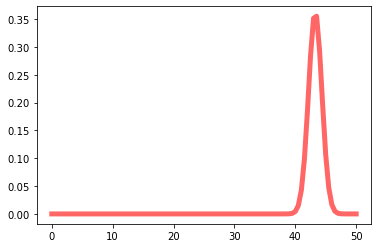

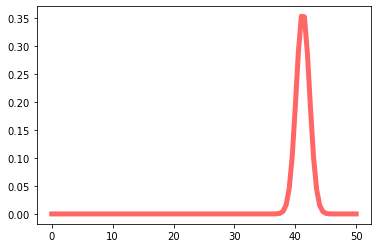

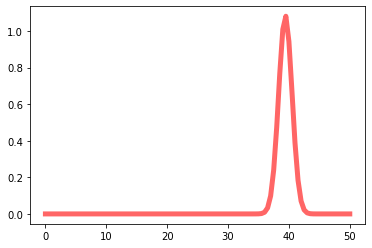

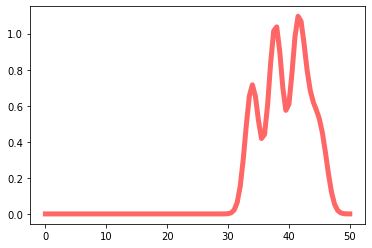

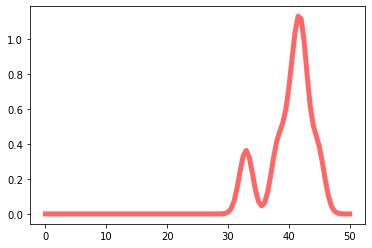

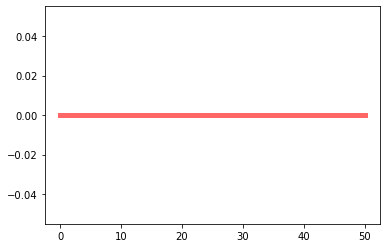

In [36]:
# Visualisation of gaussians across timepoints for a single ID 
ID = 561 
trees, times, bars_0, bars_1 = getTree(ID)
for i in range(len(bars_0)):
    fig, ax = plt.subplots(1, 1)
    pltpts = getG(get_infBirths(bars_0)[i], scale = 1.1)
    ax.plot(np.linspace(0,50,101), pltpts,
           'r-', lw=5, alpha=0.6, label='norm pdf')
    plt.show()
    plt.clf()
    plt.close()

In [37]:
# get a 2D np array, rows = gaussians. 
# 
# based on timepoint_ind:
tpt_ind = 2
ls_gauss = []
lab_gauss = []


for ind in [x for x in ELIM_ind if x in IDs]:
    trees, times, bars_0, bars_1 = getTree(ind)
    infs = get_infBirths(bars_0)[tpt_ind]
    if infs.shape[0]!=0:
        ls_gauss.append(getG(infs))
    else:
        ls_gauss.append(np.linspace(0,50,100))
    lab_gauss.append(0)

#         print(bars_0[n].shape[0])

for ind in [x for x in DIFF_ind if x in IDs]:
    trees, times, bars_0, bars_1 = getTree(ind)
    infs = get_infBirths(bars_0)[tpt_ind]
    if infs.shape[0]!=0:
        ls_gauss.append(getG(infs))
    else:
        ls_gauss.append(np.linspace(0,50,100))
    lab_gauss.append(1)

for ind in [x for x in CMPT_ind if x in IDs]:
    trees, times, bars_0, bars_1 = getTree(ind)
    infs = get_infBirths(bars_0)[tpt_ind]
    if infs.shape[0]!=0:
        ls_gauss.append(getG(infs))
    else:
        ls_gauss.append(np.linspace(0,50,100))
    lab_gauss.append(2)

In [ ]:
gauss_array = np.array(ls_gauss)

In [ ]:
# Accuracy for only gaussian vector from infinite dimensional H_0 components 
X_train, X_test, y_train, y_test = train_test_split(gauss_array, lab_gauss, test_size=0.20)
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)
lr = LogisticRegression(max_iter=50_000)
scores = cross_val_score(lr, gauss_array, lab_gauss, cv=5, n_jobs=-1)
print( pd.Series(scores).describe() )


In [94]:
# Data analysis pipeline for a single pointcloud
index = 1
xs =  coords_tumour[index][:,0].tolist() + coords_macrophage[index][:,0].tolist() + coords_vessel[index][:,0].tolist()
ys =  coords_tumour[index][:,1].tolist() + coords_macrophage[index][:,1].tolist() + coords_vessel[index][:,1].tolist()
cells = ['tumour' for i in coords_tumour[index]] + ['macrophage' for i in coords_macrophage[index]] + ['vessel' for i in coords_vessel[index]]
df = { 'x': xs, 'y': ys, 'type': cells }

In [127]:
trees, times, bars_0, bars_1 = getTree(1,EPS = 0.7 )

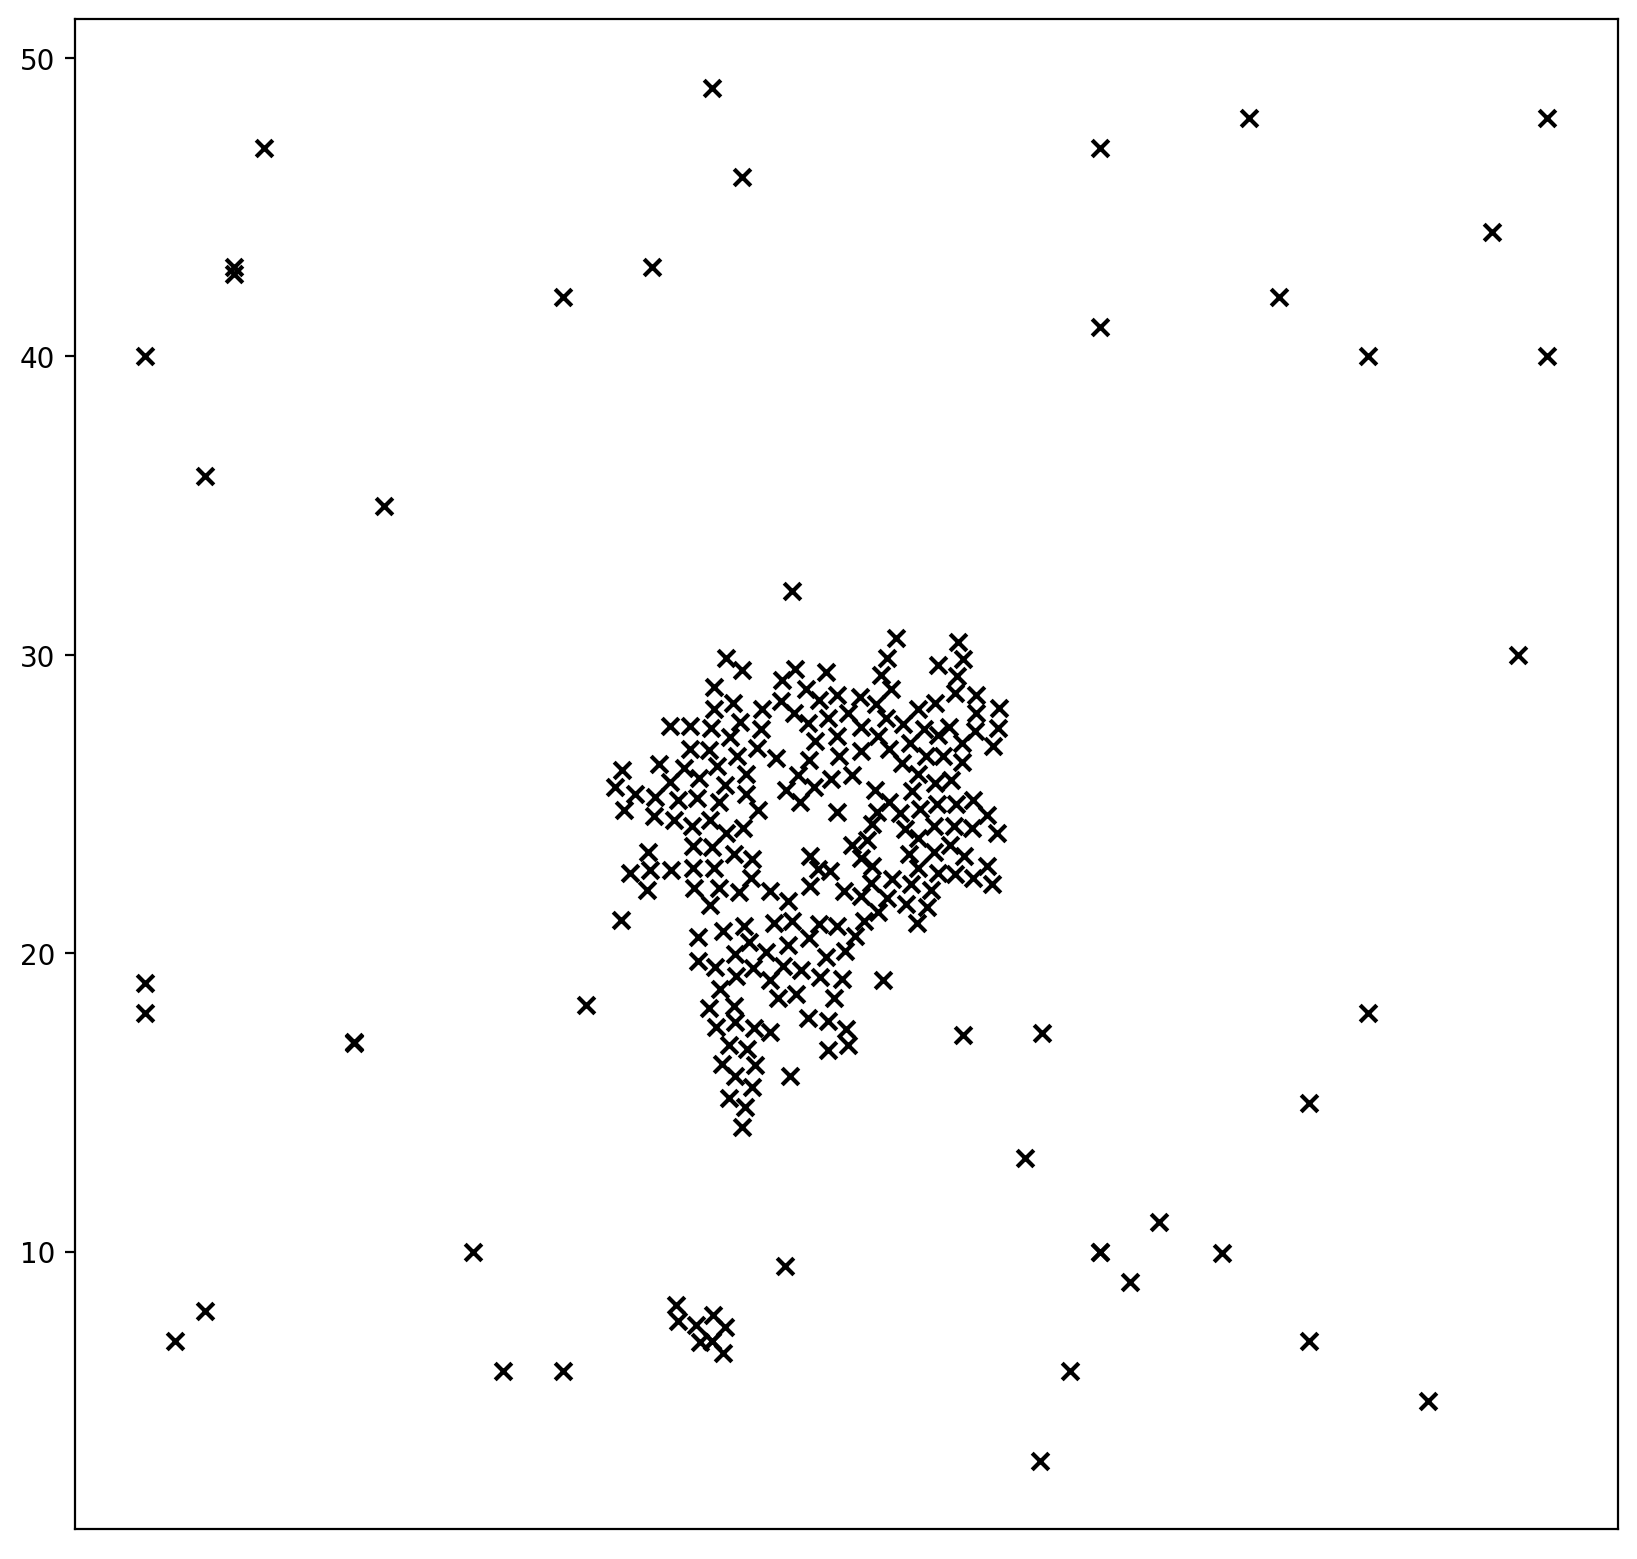

In [118]:
fig = plt.gcf()
ax = plt.gca()
plt.gca().set_aspect('equal', adjustable='box')
ax.xaxis.set_visible(False)
plt.scatter(xs,ys, marker ='x', c='black' )

fig.set_size_inches(10,10)
fig.set_dpi(200)
plt.savefig('tumours.png')

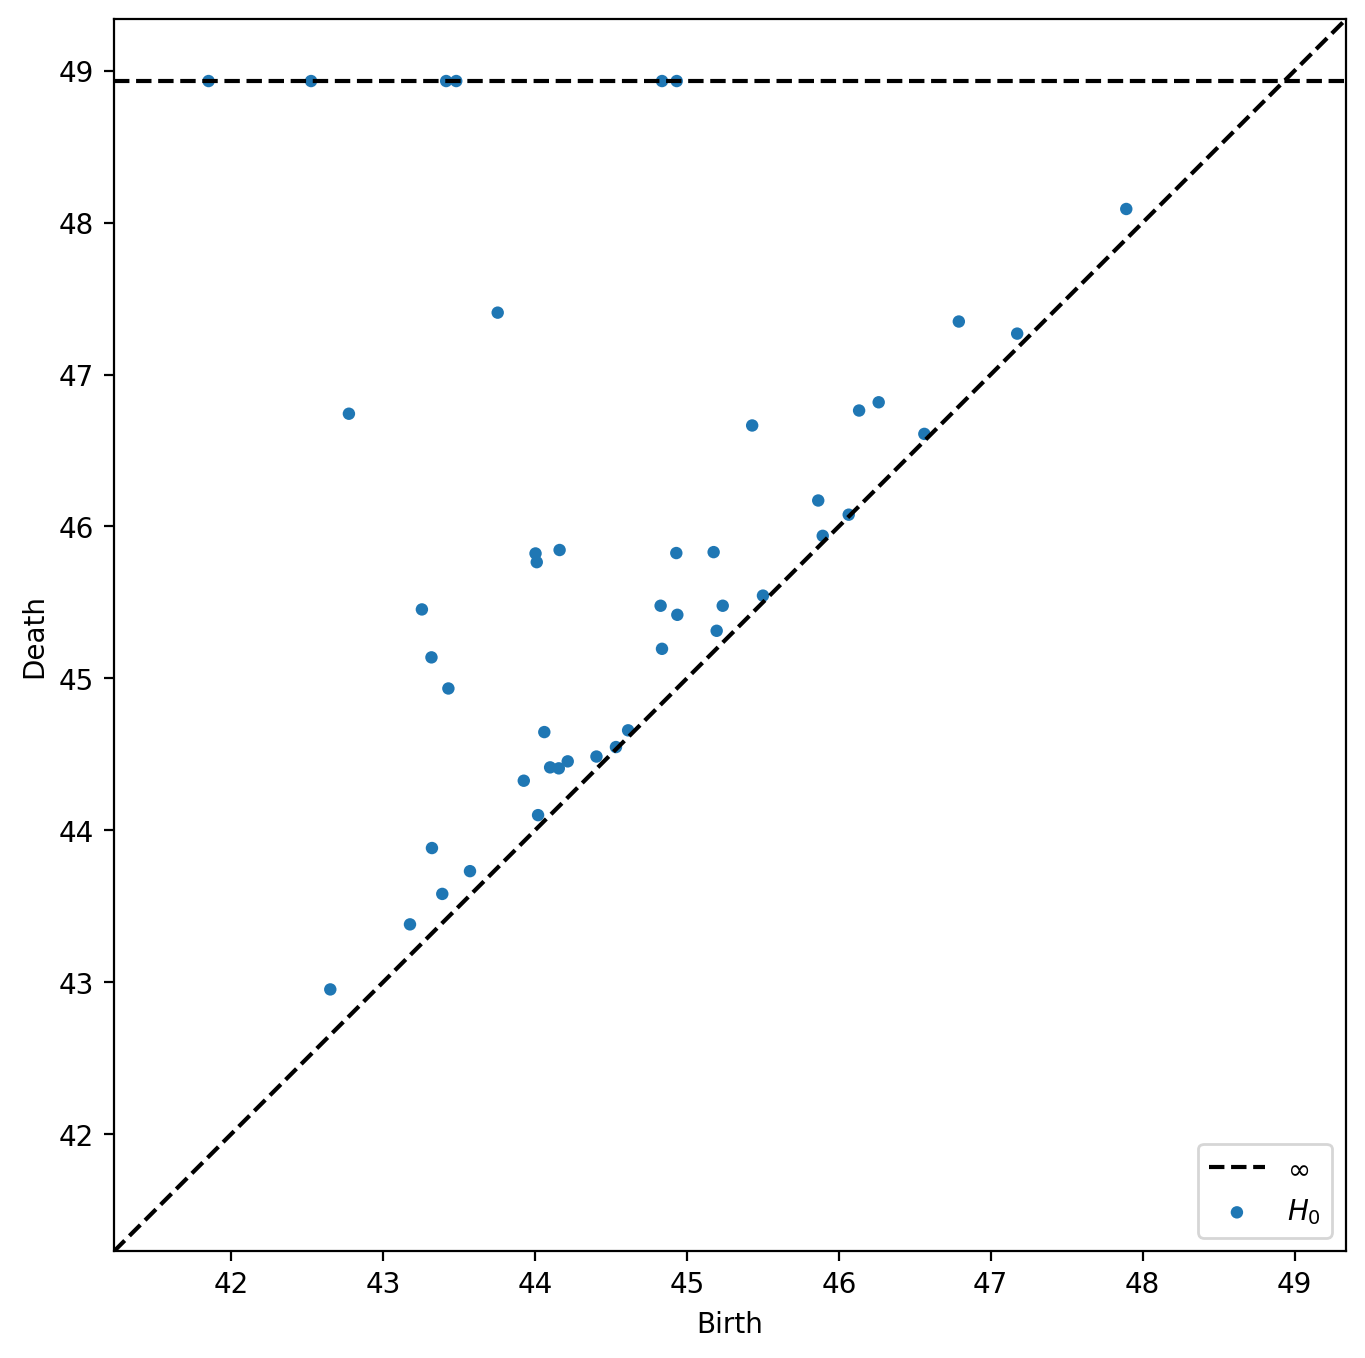

In [151]:
persim.plot_diagrams(bars_0[0])

fig = plt.gcf()

fig.set_size_inches(8,8)
fig.set_dpi(200)
plt.savefig('example_persistence.png')


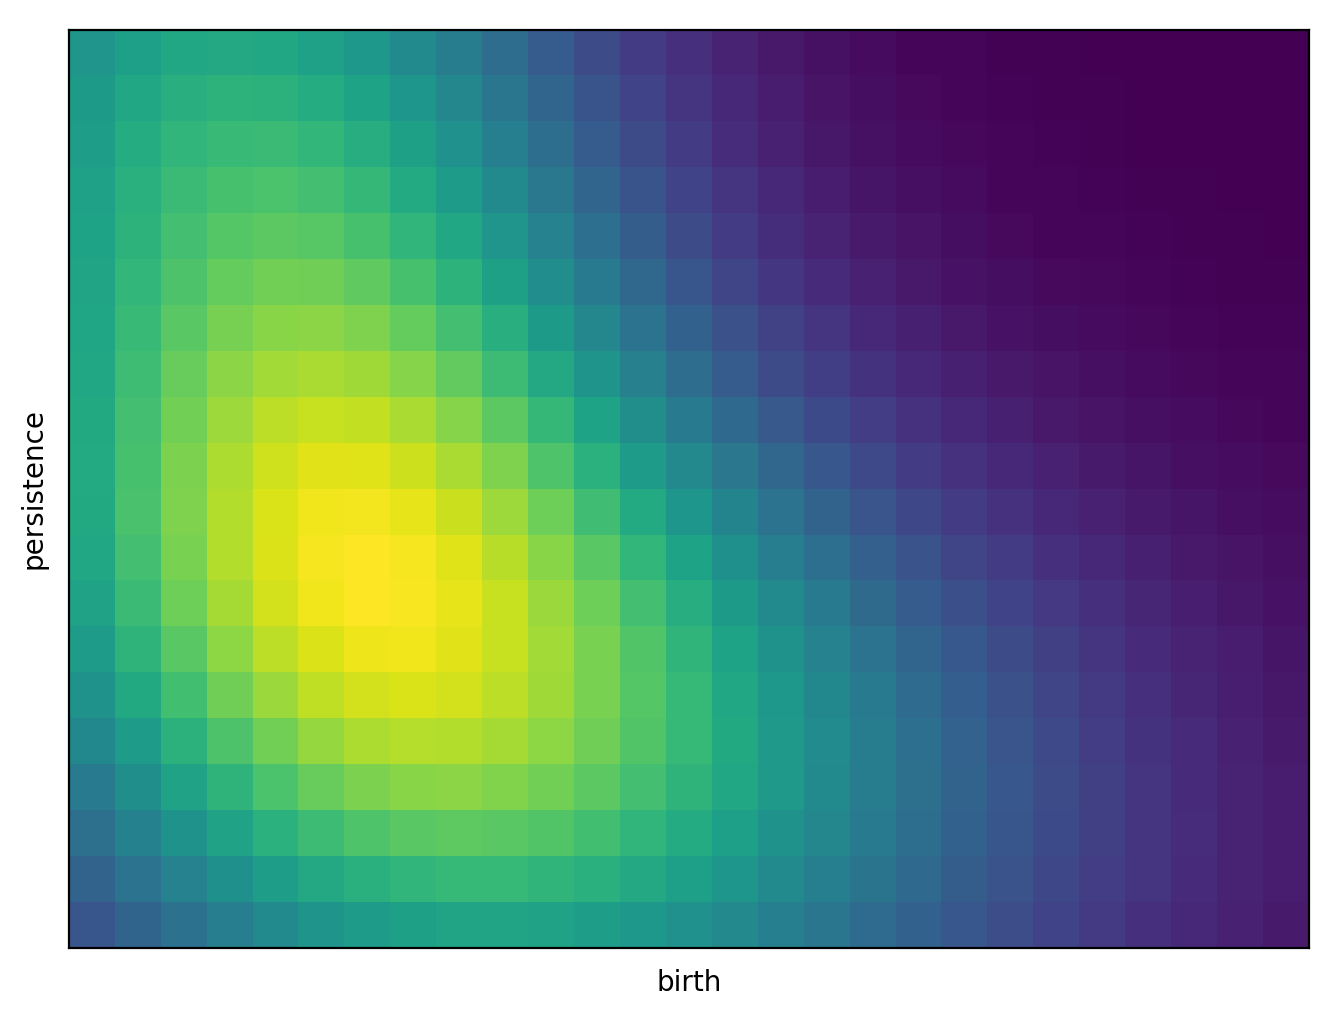

In [148]:
# Get persistence images
pimgr = PersistenceImager(pixel_size=0.2)
pimgr.fit([removeInf(bars_0)[0]])
imgs = pimgr.transform([removeInf(bars_0)[0]])

imgs_array = np.array([img.flatten() for img in imgs])

mn = np.mean([img for img in imgs], axis = 0)
ax = plt.subplot(111)
fig = plt.gcf()

fig.set_size_inches(8,8)
fig.set_dpi(200)
pimgr.plot_image(mn,ax)
plt.savefig('example_persimg.png')

C:\Users\heidi\AppData\Local\Temp\ipykernel_20288\3586683998.py:4: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.



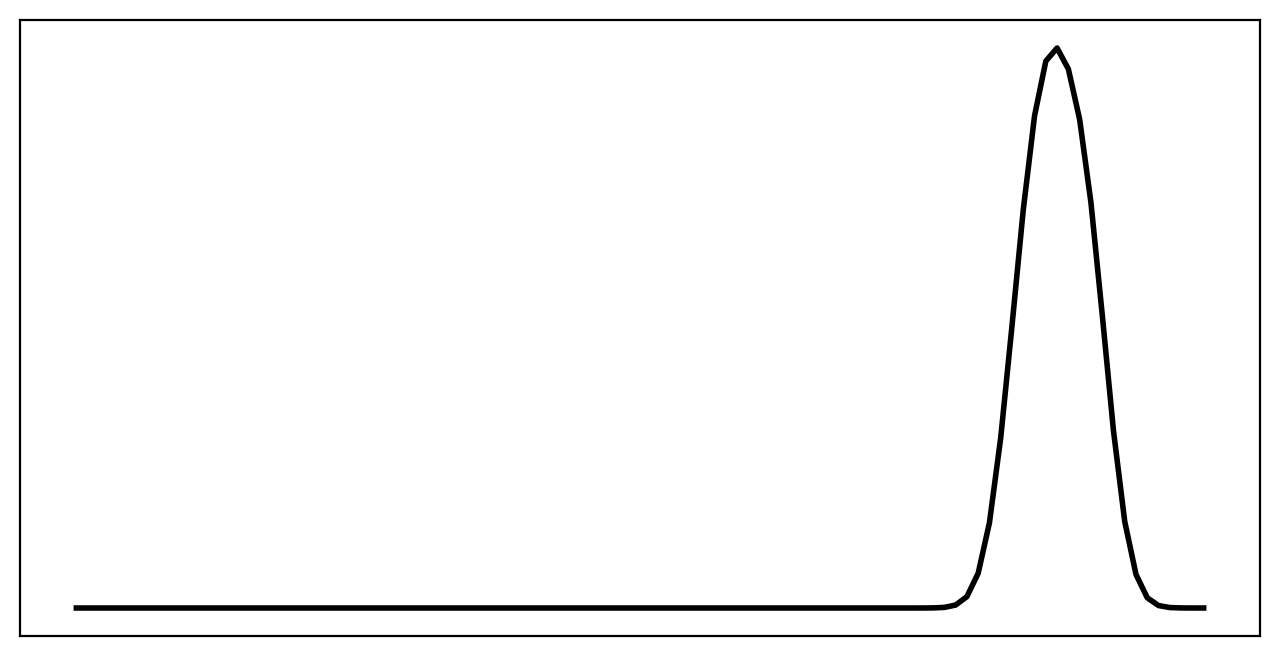

In [172]:
trees, times, bars_0, bars_1 = getTree(1, EPS = 0.7)
fig, ax = plt.subplots(1, 1)
pltpts = getG(get_infBirths(bars_0)[0], scale = 1)
ax.plot(np.linspace(0,50,101), pltpts,
       'r-', lw=2, alpha=1, label='norm pdf', c = 'black')
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
fig.set_size_inches(8,4)
fig.set_dpi(200)
plt.savefig('gaussian.png')

### Combining vectorized inf bars and remaining persistence images 

In [36]:
from sklearn.model_selection import StratifiedKFold

In [61]:
# Get elim and diff versions with inf as large
def zippedM(tpt_ind, std = 1, EPS = 0.7):
    diagrams_h0 = []
    labels_ls = []
    empty_count = []
    actual_inds = []
    for ind in metas_ind:
        counter = 0 
        trees, times, bars_0, bars_1 = getTree(ind, EPS = EPS)
        if len(bars_0) > tpt_ind:
            removed = removeInf(bars_0)[tpt_ind]
            if len(bars_0[tpt_ind]) != 0:
                if removed.size != 0:
                    diagrams_h0.append(removed)
                else:
                    diagrams_h0.append(np.zeros((1,2)))
                labels_ls.append(0)
            actual_inds.append(ind)
        else:
            counter += 1
        empty_count.append(counter)

    for ind in nonmetas_ind:
        trees, times, bars_0, bars_1 = getTree(ind, EPS = EPS)
        if len(bars_0) > tpt_ind:
            removed = removeInf(bars_0)[tpt_ind]
            if len(bars_0[tpt_ind]) != 0:
                if removed.size != 0:
                    diagrams_h0.append(removed)
                else:
                    diagrams_h0.append(np.zeros((1,2)))
                labels_ls.append(1)
            actual_inds.append(ind)
        else:
            counter+=1
        empty_count.append(counter)
    labels = np.array(labels_ls)
    pimgr = PersistenceImager(pixel_size=0.2)
    pimgr.fit(diagrams_h0)
    imgs = pimgr.transform(diagrams_h0)
    imgs_array = np.array([img.flatten() for img in imgs])
    
    # get a 2D np array, rows = gaussians. 
    # 
    # based on timepoint_ind:
    ls_gauss = []
    lab_gauss = []
    other_inds = []
    for ind in metas_ind:
        trees, times, bars_0, bars_1 = getTree(ind)
        if len(bars_0) > tpt_ind:
            infs = get_infBirths(bars_0)[tpt_ind]
            if len(bars_0[tpt_ind]) != 0:
                if infs.shape[0]!=0:
                    ls_gauss.append(getG(infs, scale = std))
                elif len(bars_0[tpt_ind]) != 0:
                    ls_gauss.append(np.linspace(0,50,100))
                lab_gauss.append(0)
                other_inds.append(ind)
    #         print(bars_0[n].shape[0])
    for ind in nonmetas_ind:
        trees, times, bars_0, bars_1 = getTree(ind)
        if len(bars_0) > tpt_ind:
            infs = get_infBirths(bars_0)[tpt_ind]
            if len(bars_0[tpt_ind]) != 0:
                if infs.shape[0]!=0:
                    ls_gauss.append(getG(infs, scale = std))
                elif len(bars_0[tpt_ind]) != 0:
                    ls_gauss.append(np.linspace(0,50,100))
                lab_gauss.append(1)
                other_inds.append(ind)

    gauss_array = np.array(ls_gauss)
#     return [gauss_array, imgs_array, actual_inds, other_inds]
    #zipping the two vectors:
    combined_array = np.hstack((gauss_array,imgs_array))
    emp_array = np.zeros((empty_count[0]+empty_count[1],len(combined_array[0])  ))
    with_zeroes_array = np.concatenate((combined_array, emp_array))
    
    labels = labels_ls + [0 for i in range(empty_count[0])] + [1 for i in range(empty_count[1])]
    return [with_zeroes_array, labels, pimgr]

In [384]:
# Get labels and vectorization without infinite components 
def noinfsM(tpt_ind, std = 1, EPS = 0.7):
    diagrams_h0 = []
    labels_ls = []
    empty_count = []
    actual_inds = []
    for ind in metas_ind:
        counter = 0 
        trees, times, bars_0, bars_1 = getTree(ind, EPS = EPS)
        if len(bars_0) > tpt_ind:
            removed = removeInf(bars_0)[tpt_ind]
            if len(bars_0[tpt_ind]) != 0:
                if removed.size != 0:
                    diagrams_h0.append(removed)
                else:
                    diagrams_h0.append(np.zeros((1,2)))
                labels_ls.append(0)
            actual_inds.append(ind)
        else:
            counter += 1
        empty_count.append(counter)

    for ind in nonmetas_ind:
        trees, times, bars_0, bars_1 = getTree(ind, EPS = EPS)
        if len(bars_0) > tpt_ind:
            removed = removeInf(bars_0)[tpt_ind]
            if len(bars_0[tpt_ind]) != 0:
                if removed.size != 0:
                    diagrams_h0.append(removed)
                else:
                    diagrams_h0.append(np.zeros((1,2)))
                labels_ls.append(1)
            actual_inds.append(ind)
        else:
            counter+=1
        empty_count.append(counter)
    labels = np.array(labels_ls)
    pimgr = PersistenceImager(pixel_size=0.2)
    pimgr.fit(diagrams_h0)
    imgs = pimgr.transform(diagrams_h0)
    imgs_array = np.array([img.flatten() for img in imgs]) 
    emp_array = np.zeros((empty_count[0]+empty_count[1],len(imgs_array[0])  ))
    with_zeroes_array = np.concatenate((imgs_array, emp_array))
    labels = labels_ls + [0 for i in range(empty_count[0])] + [1 for i in range(empty_count[1])]
    return [with_zeroes_array, labels]

In [ ]:
# Getting ML accuracy scores for all the timesteps without infinite: 
print(t)
EPS = 0.7
tpt_inds = [0,1,2,3,4,5]
ls_avescoresNoInfs = []
ls_arraysNoInfs = []
for tpt in tpt_inds:
    combined_array, labels = noinfsM(tpt, EPS= EPS)
    lr = LogisticRegression(max_iter=50_000)
    scores = []
    for i in range(10):
        cv = StratifiedKFold(n_splits = 5, shuffle = True)
        scores.append(cross_val_score(lr, combined_array, labels, cv=cv, n_jobs=-1))
    flat_scores = [item for sublist in scores for item in sublist]
    array = np.array(flat_scores)
    ls_avescoresNoInfs.append(np.mean(array))
    ls_arraysNoInfs.append(array)

In [ ]:
# Getting ML accuracy scores for all the timesteps radial vectorization: 
print(t)
EPS = 0.7
tpt_inds = [0,1,2,3,4,5]
ls_avescores = []
ls_arrays = []
# regression_coeffs = []
ls_objects = []
for tpt in tpt_inds:
    combined_array, labels, pimgr = zippedM(tpt, EPS= EPS)
    ls_objects.append([combined_array, labels])
    lr = LogisticRegression(max_iter=50_000)
    scores = []
    inverses = []
    for i in range(10):
        cv = StratifiedKFold(n_splits = 5, shuffle = True)
        scores.append(cross_val_score(lr, combined_array, labels, cv=cv, n_jobs=-1))
    flat_scores = [item for sublist in scores for item in sublist]
    array = np.array(flat_scores)
    ls_avescores.append(np.mean(array))
    ls_arrays.append(array)

In [ ]:
# box plot of radial filtration accuracies 
ls_times = []
for t in tpt_inds:
    for j in range(50):
       ls_times.append(t)
df = pd.DataFrame({'Timestep': ls_times, 'Accuracy': np.array(ls_arrays).flatten() })
fig = px.box(df, x = 'Timestep', y="Accuracy", points = 'all', color = 'Timestep',color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(showlegend=False)
fig.show()

In [ ]:
df = pd.DataFrame({'Timestep': ls_times, 'Accuracy': [item for sublist in ls_arrays for item in sublist] })
# fig = go.Figure(data = [go.Box(df, x = 'Timestep', y = "Accuracy")])
fig = px.box(df, x = 'Timestep', y="Accuracy", points = 'all', color = 'Timestep',color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(showlegend=False)
fig.show()

In [75]:
from scipy.spatial.distance import cdist

def getDist(ind, timept):
    inds = np.where(np.array(IDs) == ind)
    tumour = coords_tumour[inds[0][timept]]
    vessels = coords_vessel[inds[0][timept]]
    return np.min(np.min(cdist(tumour,vessels)))

In [80]:
# Tumour cell dist to vessel benchmark accuracy scores:
from sklearn.model_selection import RepeatedStratifiedKFold
tpt_inds = [0,1,2,3,4,5]
total_scores_TV = []
average_scores_TV= []
for tpt_ind in tpt_inds:
    labels_d = []
    dists = []
    for ind in metas_ind:
        inds = np.where(np.array(IDs) == ind)
        if len(inds[0]) > tpt_ind:
            tumour = coords_tumour[inds[0][tpt_ind]]
            if len(tumour) > 0:
                vessels = coords_vessel[inds[0][tpt_ind]]
                dists.append(np.array([np.min(np.min(cdist(tumour,vessels)))]))
                labels_d.append(0)
    for ind in nonmetas_ind:
        inds = np.where(np.array(IDs) == ind)
        if len(inds[0]) > tpt_ind:
            tumour = coords_tumour[inds[0][tpt_ind]]
            if len(tumour) > 0:
                vessels = coords_vessel[inds[0][tpt_ind]]
                dists.append(np.array([np.min(np.min(cdist(tumour,vessels)))]))
                labels_d.append(1)
    dists_array = np.array(dists)
    lr = LogisticRegression(max_iter=50_000)
    scores = []
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10, random_state = 42)
    scores.append(cross_val_score(lr, dists_array, labels_d, cv=cv, n_jobs=-1))
    total_scores_TV.append(np.concatenate(scores).ravel())
    average_scores_TV.append(np.mean(np.concatenate(scores).ravel()))
total_scores_TV = np.array(total_scores_TV)

In [ ]:
# Tumour cell count benchmark accuracy scores:
tpt_inds = [0,1,2,3,4,5]
total_scores = []
average_scores_TC = []
for tpt_ind in tpt_inds:
    labels_tumour = []
    counts = []
    for ind in metas_ind:
        inds = np.where(np.array(IDs) == ind)
        if len(inds[0]) > tpt_ind:
            counts.append(np.array([len(coords_tumour[inds[0][tpt_ind]])]))
            labels_tumour.append(0)
    for ind in nonmetas_ind:
        inds = np.where(np.array(IDs) == ind)
        if len(inds[0]) > tpt_ind:
            counts.append(np.array([len(coords_tumour[inds[0][tpt_ind]])]))
            labels_tumour.append(1)
    counts_array = np.array(counts)
    lr = LogisticRegression(max_iter=50_000)
    scores = []
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10, random_state = 42)
    scores.append(cross_val_score(lr, counts_array, labels_tumour, cv=cv, n_jobs=-1))
    total_scores_TC.append(np.concatenate(scores).ravel())
    average_scores_TC.append(np.mean(np.concatenate(scores).ravel()))
total_scores_TC = np.array(total_scores_TC)

In [ ]:
ls_times = []
for i in range(6):
    for j in range(50):
        ls_times.append([250,300,350,400,450,500][i])

df = pd.DataFrame({'Timestep': ls_times, 'Accuracy': total_scores.flatten() })
# fig = go.Figure(data = [go.Box(df, x = 'Timestep', y = "Accuracy")])
fig = px.box(df, x = 'Timestep', y="Accuracy", points = 'all', color = 'Timestep',color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(showlegend=False)
fig.show()

In [ ]:
# Plot of benchmarks together:
import plotly.express as px
import plotly.graph_objects as go
ls_times = []
for t in tpt_inds:
    for j in range(50):
        ls_times.append([250,300,350,400,450,500][t])

df = pd.DataFrame({'Timestep': ls_times, 'Accuracy': np.array(ls_arrays).flatten() })
# fig = go.Figure(data = [go.Box(df, x = 'Timestep', y = "Accuracy")])
fig = px.box(df, x = 'Timestep', y="Accuracy", points = 'all', color = 'Timestep',color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(showlegend=False)

fig.add_trace(go.Scatter( name = 'Tumour Count',
x = [250,300,350,400,450,500], y = average_scores_TC, mode = 'lines', line = dict(color='black', dash = 'dash')))
fig.add_trace(go.Scatter( name = 'Tumour-Vessel Distance', x = [250,300,350,400,450,500], y = average_scores_TV, mode = 'lines', line = dict(color = 'blue', dash = 'dash')))


fig.add_trace(go.Scatter( name = 'Macrophage Phenotype', x = [250,300,350,400,450,500], y = [0.69737374, 0.72781145, 0.79259259, 0.81171717, 0.82141414,0.80444444], mode = 'lines', line = dict(color = 'red', dash = 'dash')))

fig.update_layout(legend_title_text=None)
fig.show()